# BOLD models

Download the Jupyter notebook: [BoldModel.ipynb](https://raw.githubusercontent.com/ANNarchy/CNS2023/master/src/notebooks/BoldModel.ipynb){target="_blank"} or run it directly on [colab.](https://colab.research.google.com/github/ANNarchy/CNS2023/blob/master/src/notebooks/BoldModel.ipynb){target="_blank"}

In [1]:
#!pip install ANNarchy

Let's now demonstrate how to define a custom BOLD model. The default Ballon model is defined by the following code:

```python
balloon_RN = BoldModel(
    parameters = """
        phi       = 1.0         ;   kappa     = 1/1.54
        gamma     = 1/2.46      ;   E_0       = 0.34
        tau       = 0.98        ;   alpha     = 0.33
        V_0       = 0.02        ;   v_0       = 40.3
        TE        = 40/1000.    ;   epsilon   = 1.43
        r_0       = 25.         ;   second    = 1000.0
    """,
    equations = """
        # CBF input
        I_CBF          = sum(I_CBF)       
        ds/dt          = (phi * I_CBF - kappa * s - gamma * (f_in - 1))/second  
        df_in/dt       = s / second                                                : init=1, min=0.01

        # Balloon model
        E              = 1 - (1 - E_0)**(1 / f_in)                                 : init=0.3424
        dq/dt          = (f_in * E / E_0 - (q / v) * f_out)/(tau*second)           : init=1, min=0.01
        dv/dt          = (f_in - f_out)/(tau*second)                               : init=1, min=0.01
        f_out          = v**(1 / alpha)                                            : init=1, min=0.01

        # Revised coefficients
        k_1            = 4.3 * v_0 * E_0 * TE
        k_2            = epsilon * r_0 * E_0 * TE
        k_3            = 1.0 - epsilon

        # Non-linear BOLD equation
        BOLD           = V_0 * (k_1 * (1 - q) + k_2 * (1 - (q / v)) + k_3 * (1 - v))
    """,
    inputs=['I_CBF']
)
```

It is very similar to the interface of a Neuron model, with parameters and equations defined in two multi-line strings. The input signal `I_CBF` has to be explicitly defined in the `inputs` argument to help the BOLD monitor create the mapping. 

To demonstrate how to create a custom BOLD model, let's suppose we want a model that computes both the BOLD signal of the Balloon model and the one of the Davis model:

> Davis, T. L., Kwong, K. K., Weisskoff, R. M., and Rosen, B. R. (1998). Calibrated functional MRI: mapping the dynamics of oxidative metabolism. Proceedings of the National Academy of Sciences 95, 1834–1839

Without going into too many details, the Davis model computes the BOLD signal directly using `f_in` and `E`, without introducing a differential equation for the BOLD signal. Its implementation using the BOLD model would be:

```python
DavisModel = BoldModel(
    parameters = """
        second = 1000.0
        
        phi    = 1.0    # Friston et al. (2000)
        kappa  = 1/1.54
        gamma  = 1/2.46
        E_0    = 0.34
        
        M      = 0.149   # Griffeth & Buxton (2011)
        alpha  = 0.14
        beta   = 0.91
    """,
    equations = """
        # CBF-driving input as in Friston et al. (2000)
        I_CBF    = sum(I_CBF)                                             : init=0
        ds/dt    = (phi * I_CBF - kappa * s - gamma * (f_in - 1))/second  : init=0
        df_in/dt = s  / second                                            : init=1, min=0.01
    ​
        # Using part of the Balloon model to calculate r (normalized CMRO2) as in Buxton et al. (2004)
        E        = 1 - (1 - E_0)**(1 / f_in)                              : init=0.34
        r        = f_in * E / E_0
        
        # Davis model
        BOLD     = M * (1 - f_in**alpha * (r / f_in)**beta)               : init=0
    """,
    inputs=['I_CBF']
)
```

Note that we could simply define two BOLD monitors using different models, but let's create a complex model that does both for the sake of demonstration.

Let's first redefine the population of the previous section:

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from ANNarchy import *
from ANNarchy.extensions.bold import *
clear()

# One populations of 100 izhikevich neurons
pop = Population(100, neuron=Izhikevich)

# Set noise to create some baseline activity
pop.noise = 5.0

# Compute mean firing rate in Hz on 100ms window
pop.compute_firing_rate(window=100.0)

# Create required monitor
m_rate = Monitor(pop, ["r"], start=False)

ANNarchy 4.7 (4.7.2.5) on darwin (posix).


We can now create a hybrid model computing both the Balloon RN model of Stephan et al. (2007) and the Davis model:

In [3]:
balloon_Davis = BoldModel(
    parameters = """
        phi       = 1.0         ;   kappa     = 1/1.54
        gamma     = 1/2.46      ;   E_0       = 0.34
        tau       = 0.98        ;   alpha     = 0.33
        V_0       = 0.02        ;   v_0       = 40.3
        TE        = 40/1000.    ;   epsilon   = 1.43
        r_0       = 25.         ;   second    = 1000.0
        M         = 0.062       ;   alpha2    = 0.14
        beta      = 0.91
    """,
    equations = """
        # CBF input
        I_CBF          = sum(I_CBF)       
        ds/dt          = (phi * I_CBF - kappa * s - gamma * (f_in - 1))/second  
        df_in/dt       = s / second                                                : init=1, min=0.01

        # Balloon model
        E              = 1 - (1 - E_0)**(1 / f_in)                                 : init=0.3424
        dq/dt          = (f_in * E / E_0 - (q / v) * f_out)/(tau*second)           : init=1, min=0.01
        dv/dt          = (f_in - f_out)/(tau*second)                               : init=1, min=0.01
        f_out          = v**(1 / alpha)                                            : init=1, min=0.01

        # Revised coefficients
        k_1            = 4.3 * v_0 * E_0 * TE
        k_2            = epsilon * r_0 * E_0 * TE
        k_3            = 1.0 - epsilon

        # Ballon RN model
        BOLD    = V_0 * (k_1 * (1 - q) + k_2 * (1 - (q / v)) + k_3 * (1 - v))
        
        # Davis model
        r = f_in * E / E_0                                                         : init=1, min=0.01
        BOLD_Davis =  M * (1 - f_in**alpha2 * (r / f_in)**beta) 
    """,
    inputs=['I_CBF']
)

We now only need to pass that new object to the BOLD monitor, and specify that we want to record both `BOLD` and `BOLD_Davis`:

In [4]:
m_bold = BoldMonitor(
    
    populations = [pop],  
    
    bold_model = balloon_Davis,
    
    mapping={'I_CBF': 'r'},            
    
    normalize_input=2000, 
    
    recorded_variables=["I_CBF", "BOLD", "BOLD_Davis"]
)

compile()

Compiling ...  OK 


We run the same simulation protocol and compare the two BOLD signals. Note that the value of `M` has been modified to give a similar amplitude to both signals:

In [5]:
# Ramp up time
simulate(2000)

# Start recording
m_rate.start()
m_bold.start()

# Simulation
simulate(5000)      # 5s with low noise
pop.noise = 7.5
simulate(5000)      # 5s with higher noise (one population)
pop.noise = 5
simulate(20000)     # 20s with low noise

# retrieve the recordings
mean_fr = np.mean(m_rate.get("r"), axis=1)
input_data = m_bold.get("I_CBF")
bold_data = m_bold.get("BOLD")
davis_data = m_bold.get("BOLD_Davis")

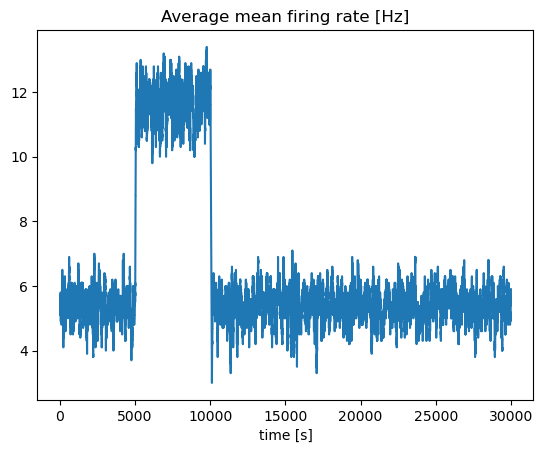

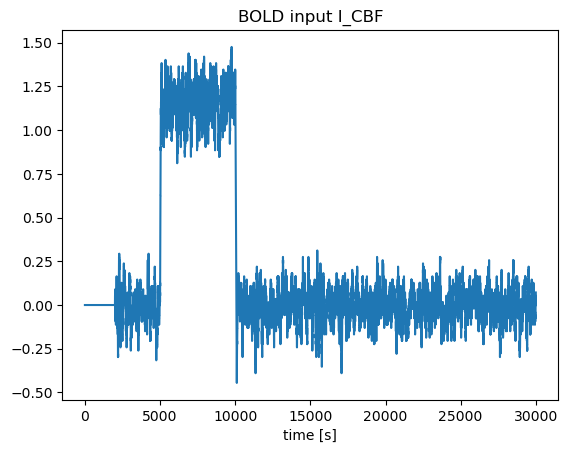

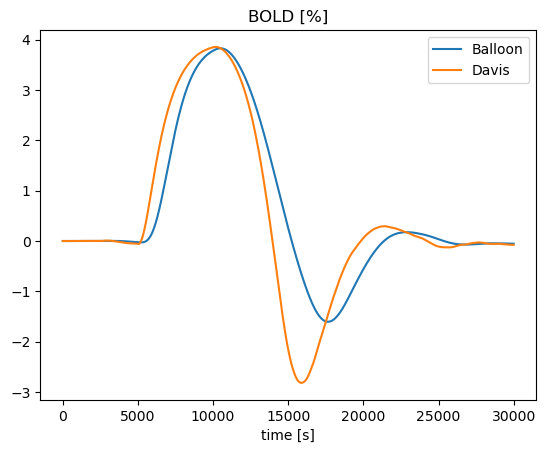

In [6]:
# Firing rate
plt.figure()
plt.plot(mean_fr, label="pop")
plt.title("Average mean firing rate [Hz]")
plt.xlabel("time [s]")

# BOLD input signal
plt.figure()
plt.plot(input_data)
plt.title("BOLD input I_CBF")
plt.xlabel("time [s]")

# BOLD output signal
plt.figure()
plt.plot(bold_data*100.0, label="Balloon")
plt.plot(davis_data*100.0, label="Davis")
plt.legend()
plt.title("BOLD [%]")
plt.xlabel("time [s]")

plt.show()